In [1]:
import optuna
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

c:\Users\Pradhyumnaa G\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# 1 Load Dataset

df = pd.read_csv("Dataset/Cleaned.csv")

# Feature/target selection
X = df.drop(columns=["NSP", "CLASS"])

y = df["CLASS"] - 1

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((1700, 21), (426, 21))

In [ ]:
# 2 Optuna Hyperparameter Search

def objective(trial):

    params = {
        "objective": "multiclass",
        "num_class": 10,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "num_leaves": trial.suggest_int("num_leaves", 31, 200),
        "max_depth": trial.suggest_int("max_depth", -1, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 200),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "n_estimators": trial.suggest_int("n_estimators", 300, 2000),
        "random_state": 42,
        "verbosity": -1
    }

    model = LGBMClassifier(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="multi_logloss",
        callbacks=[],
    )

    preds = model.predict(X_test)
    macro_f1 = f1_score(y_test, preds, average="macro")
    
    return macro_f1

In [4]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Best trial:")
print(study.best_trial.params)

[I 2025-11-30 21:48:29,279] A new study created in memory with name: no-name-0420a8db-e345-4df1-9fdf-2de0b75ef3b0
[I 2025-11-30 21:48:31,398] Trial 0 finished with value: 0.8278057308370947 and parameters: {'learning_rate': 0.11673110311012143, 'num_leaves': 60, 'max_depth': 10, 'min_child_samples': 80, 'min_child_weight': 8.756268958470242, 'subsample': 0.8915834374362337, 'subsample_freq': 9, 'colsample_bytree': 0.907039817926056, 'reg_lambda': 4.344961423984955, 'reg_alpha': 1.3198819329299045, 'n_estimators': 838}. Best is trial 0 with value: 0.8278057308370947.
[I 2025-11-30 21:48:32,571] Trial 1 finished with value: 0.8544925270504293 and parameters: {'learning_rate': 0.07944989777870924, 'num_leaves': 31, 'max_depth': 10, 'min_child_samples': 138, 'min_child_weight': 3.989314712574474, 'subsample': 0.7592026911192417, 'subsample_freq': 5, 'colsample_bytree': 0.6606362383092762, 'reg_lambda': 4.435149916116291, 'reg_alpha': 2.594724221942841, 'n_estimators': 1834}. Best is trial 

Best trial:
{'learning_rate': 0.041865953166234315, 'num_leaves': 99, 'max_depth': 11, 'min_child_samples': 48, 'min_child_weight': 2.8340578046787246, 'subsample': 0.8615620789543492, 'subsample_freq': 1, 'colsample_bytree': 0.8396296691187829, 'reg_lambda': 0.6903426356472987, 'reg_alpha': 0.13490738848748807, 'n_estimators': 1230}


In [ ]:
# 3 Create model based on Optuna's Search

best_params = study.best_trial.params

best_model = LGBMClassifier(
    objective="multiclass",
    num_class=10,
    metric="multi_logloss",
    random_state=42,
    verbosity=-1,
    **best_params
)

best_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="multi_logloss",
)

,boosting_type,'gbdt'
,num_leaves,99
,max_depth,11
,learning_rate,0.041865953166234315
,n_estimators,1230
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,2.8340578046787246
,min_child_samples,48


Final Accuracy: 0.9178403755868545
Final Macro F1: 0.8761216611042932

Classification Report:
              precision    recall  f1-score   support

         1.0       0.91      0.96      0.94        77
         2.0       0.90      0.97      0.93       116
         3.0       1.00      0.55      0.71        11
         4.0       1.00      0.75      0.86        16
         5.0       0.89      0.57      0.70        14
         6.0       0.97      0.90      0.93        67
         7.0       0.92      0.92      0.92        51
         8.0       0.87      0.95      0.91        21
         9.0       0.88      1.00      0.93        14
        10.0       0.90      0.97      0.94        39

    accuracy                           0.92       426
   macro avg       0.92      0.85      0.88       426
weighted avg       0.92      0.92      0.91       426



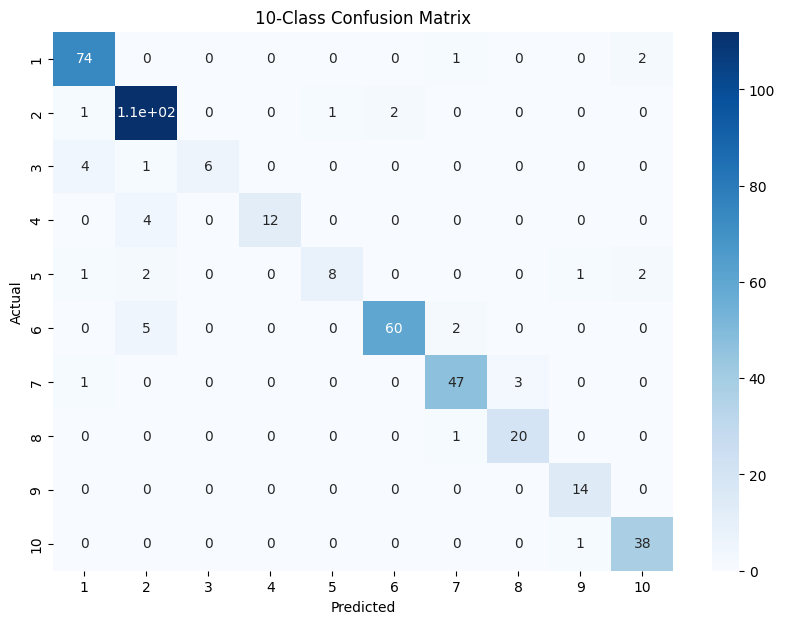

In [ ]:
# 4 Evaluate Model and Print Confusion Matrix

preds = best_model.predict(X_test)

# Map back 0..9 → 1..10
preds_original = preds + 1
y_test_original = y_test + 1

acc = accuracy_score(y_test_original, preds_original)
macro_f1 = f1_score(y_test_original, preds_original, average="macro")

print("Final Accuracy:", acc)
print("Final Macro F1:", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test_original, preds_original))

labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
cm = confusion_matrix(y_test_original, preds_original, labels=labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=labels, yticklabels=labels, fmt='g')
plt.title("10-Class Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()